In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# 定义函数
def him(x):
    return (x[0]**2+x[1]-11)**2 + (x[0]+x[1]**2-1)**2

In [4]:
x = np.arange(-6,6,0.1)
y = np.arange(-6,6,0.1)

In [5]:
x.shape

(120,)

In [6]:
X,Y = np.meshgrid(x,y)

In [9]:
X.shape

(120, 120)

In [10]:
Z = him([X,Y])

Text(0.5, 0, 'y')

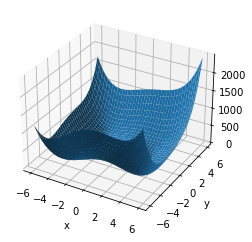

In [22]:
fig = plt.figure()
ax = fig.gca(projection= '3d')
ax.plot_surface(X,Y,Z)
# ax.view_init(60,-30)
ax.set_xlabel('x')
ax.set_ylabel('y')

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets,layers,optimizers,Sequential,metrics 

In [33]:
#极值点
x = tf.constant([-1.,-5.])
for step in range(200):
    with tf.GradientTape() as tape:
        tape.watch([x])
        y = him(x)
    grads = tape.gradient(y,[x])[0]
    x -=0.005*grads
    if step%20 ==0:
        print('step {}:x = {} ,f(x) = {}'.format(step,x.numpy(),y.numpy()))

step 0:x = [-1.53 -2.55] ,f(x) = 754.0
step 20:x = [-3.6143892 -2.1111305] ,f(x) = 0.03769447281956673
step 40:x = [-3.6260295 -2.1496432] ,f(x) = 3.970244506490417e-05
step 60:x = [-3.6264064 -2.1508718] ,f(x) = 3.8105099520180374e-08
step 80:x = [-3.626418 -2.15091 ] ,f(x) = 3.3651303965598345e-11
step 100:x = [-3.626418  -2.1509104] ,f(x) = 1.1823431123048067e-11
step 120:x = [-3.626418  -2.1509104] ,f(x) = 1.1823431123048067e-11
step 140:x = [-3.626418  -2.1509104] ,f(x) = 1.1823431123048067e-11
step 160:x = [-3.626418  -2.1509104] ,f(x) = 1.1823431123048067e-11
step 180:x = [-3.626418  -2.1509104] ,f(x) = 1.1823431123048067e-11


In [81]:
 (x,y),(x_test,y_test) = datasets.fashion_mnist.load_data()

In [28]:
x.shape

(60000, 28, 28)

In [82]:
#转化为tensor形式
batchsz =128
def prerocess(x,y):
    x = tf.cast(x,dtype=tf.float32) / 255.
    y = tf.cast(y,dtype=tf.int32)
    return x,y
db = tf.data.Dataset.from_tensor_slices((x,y))
db = db.map(prerocess).shuffle(10000).batch(batchsz)
db_test = tf.data.Dataset.from_tensor_slices((x_test,y_test))
db_test = db_test.map(prerocess).batch(batchsz)

In [78]:
db

<BatchDataset shapes: ((None, 784), (None,)), types: (tf.float32, tf.int32)>

In [87]:
# 生成迭代器
db_iter = iter(db)
sample = next(db_iter)[0]

In [88]:
sample.shape

TensorShape([128, 28, 28])

In [58]:
sample = tf.reshape(sample[0],[1,28,28,1])

In [61]:
sample.shape

TensorShape([1, 28, 28, 1])

In [17]:
model = Sequential([
    layers.Dense(256,activation = tf.nn.relu),  #[b,784] -> [b,256]
    layers.Dense(128,activation = tf.nn.relu),  #[b,256] -> [b,128]
    layers.Dense(64,activation = tf.nn.relu),  #[b,128] -> [b,64]
    layers.Dense(32,activation = tf.nn.relu),  #[b,64] -> [b,32] 330 = 32*10 +10
    layers.Dense(10)  #[b,32] -> [b,10]
])
optimizer = optimizers.Adam(learning_rate= 1e-3) 
model.build(input_shape=[None,28*28])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_21 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_22 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_23 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_24 (Dense)             (None, 10)                330       
Total params: 244,522
Trainable params: 244,522
Non-trainable params: 0
_________________________________________________________________


In [43]:
#创建tensorboard 监控日志
import datetime
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'logs/' +current_time
summary_writer = tf.summary.create_file_writer(log_dir)
# tensorboard --logdir logs 生成localhost

In [99]:
for epoch in range(5):
    for step,(x,y) in enumerate(db):
        x = tf.reshape(x,[-1,28*28])
        with tf.GradientTape() as tape:
            #[b,28*28] -> [b,10]
            logits = model(x)
            y_onehot = tf.one_hot(y,depth= 10)
            #[b]
            loss_mse = tf.reduce_mean(tf.losses.MSE(y_onehot,logits))
            loss_entropy = tf.losses.categorical_crossentropy(y_onehot,logits,from_logits= True)
            loss_entropy = tf.reduce_mean(loss_entropy)
        grad = tape.gradient(loss_entropy,model.trainable_variables)
        optimizer.apply_gradients(zip(grad,model.trainable_variables))
        
        if step %100 == 0:
            print(epoch,step,'loss:',float(loss_entropy),float(loss_mse))
            with summary_writer.as_default():
                tf.summary.scalar('loss',float(loss_entropy),step = epoch)
                
        if step% 500 == 0:            
            #test
            total_correct = 0
            total_num = 0
            for x1,y in db_test:
                x1 = tf.reshape(x1,[-1,28*28])
                #[b,10]
                lo = model(x1)
                prob = tf.nn.softmax(lo,axis = 1)
                # [b,10] -> [b]
                pre = tf.argmax(prob,axis =1)
                pre = tf.cast(pre,dtype=tf.int32)
                correct = tf.equal(pre,y)
                correct = tf.reduce_sum(tf.cast(correct, dtype= tf.int32))

                total_correct +=int(correct)
                total_num += x.shape[0]        
            acc = total_correct / total_num
            print('acc',acc)
            #给日志喂数据
#             print(x.shape)
            val_images = x[:25]
            val_images = tf.reshape(val_images,[-1,28,28,1])
            with summary_writer.as_default():
                tf.summary.scalar('accuracy',float(acc),step = step)
                tf.summary.image("one_by_one image",val_images,max_outputs=25,step = step)

                val_images = tf.reshape(val_images,[-1,28,28])
                figure = image_grid(val_images)
                tf.summary.image("val_images",plot_to_image(figure),step = step)

0 0 loss: 0.0832052156329155 855.3209228515625
acc 0.8816257911392406
(128, 784)
0 100 loss: 0.04464051499962807 1175.01123046875
0 200 loss: 0.14992184937000275 1066.5733642578125
0 300 loss: 0.13362371921539307 907.885009765625
0 400 loss: 0.0781790167093277 904.991943359375
1 0 loss: 0.07326298952102661 1113.9686279296875
acc 0.879746835443038
(128, 784)
1 100 loss: 0.061533037573099136 1140.7003173828125
1 200 loss: 0.1715640127658844 884.7759399414062
1 300 loss: 0.1270952969789505 898.1318359375
1 400 loss: 0.13586120307445526 864.06396484375
2 0 loss: 0.08028330653905869 971.5485229492188
acc 0.8829113924050633
(128, 784)
2 100 loss: 0.1186433881521225 971.1226196289062
2 200 loss: 0.07413042336702347 882.0765380859375
2 300 loss: 0.03550940379500389 873.6038208007812
2 400 loss: 0.11954016983509064 901.9700927734375
3 0 loss: 0.08054899424314499 1189.42529296875
acc 0.882120253164557
(128, 784)
3 100 loss: 0.07810188829898834 1005.1734619140625
3 200 loss: 0.08373983949422836 1

In [98]:
import matplotlib.pyplot as plt
import io
#将图片聚合的接口函数
def image_grid(images):
    figure = plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1,title = "name")
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i],cmap = plt.cm.binary)
    return figure

def plot_to_image(figure):
    buf = io.BytesIO()
    plt.savefig(buf,format = 'png')
    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(),channels = 4)
    image = tf.expand_dims(image,0)
    return image


In [40]:
with summary_writer.as_default():
    tf.summary.scalar('loss',float(loss_entropy),step = epoch)
    tf.summary.scalar('accuracy',float(acc),step = epoch)
    # tf.summary.image() 图片数据 max_outputs = (可喂多个图片)